Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from six.moves import range
import tensorflow as tf

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception('Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
import random

num_images = 0
for folder in train_folders:
    print(folder)
    for image in os.listdir(folder):
        display(Image(folder + "\\" + image))
        num_images += 1
        if (num_images % 3 == 0):
            num_images = 0
            break

./notMNIST_large/A


./notMNIST_large/B


./notMNIST_large/C


./notMNIST_large/D


./notMNIST_large/E


./notMNIST_large/F


./notMNIST_large/G


./notMNIST_large/H


./notMNIST_large/I


./notMNIST_large/J


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [5]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                             dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

/Users/f.riols/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


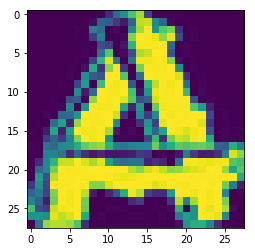

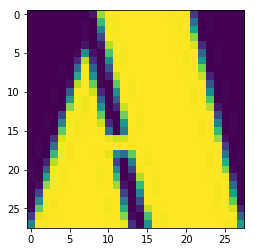

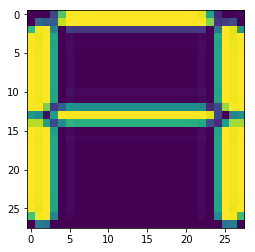

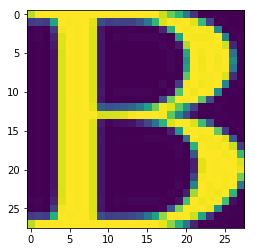

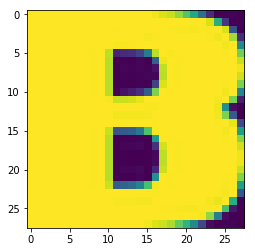

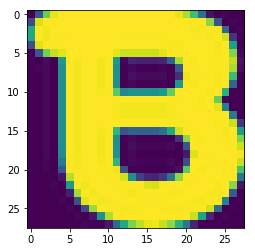

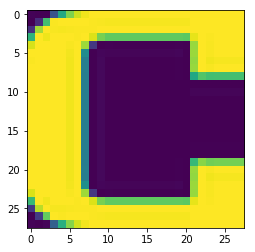

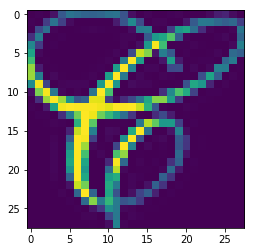

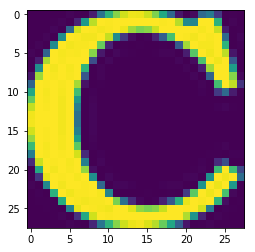

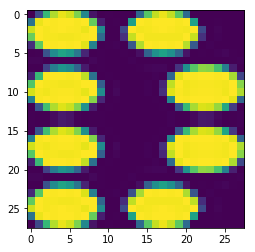

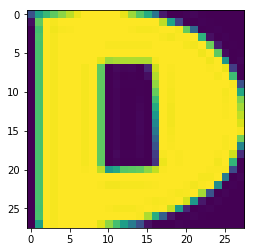

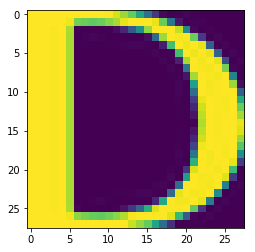

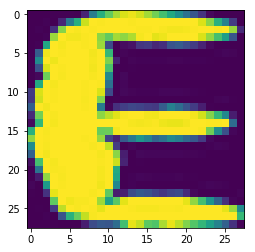

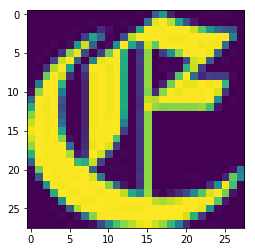

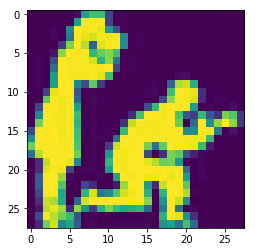

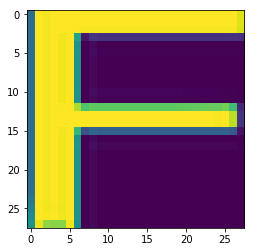

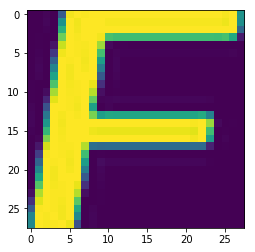

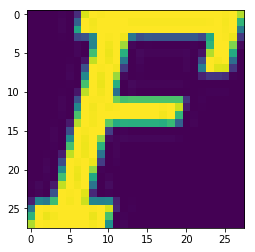

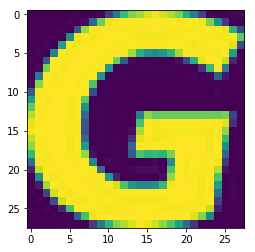

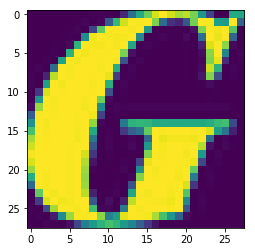

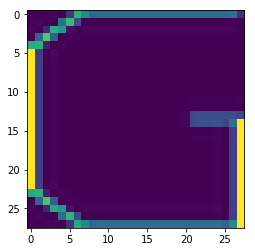

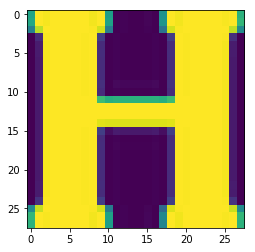

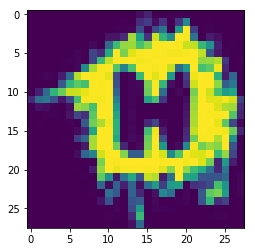

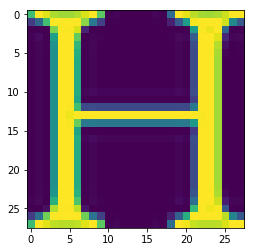

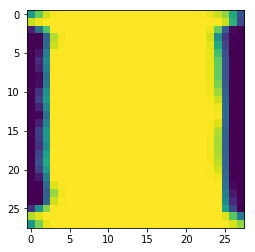

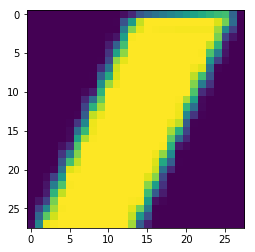

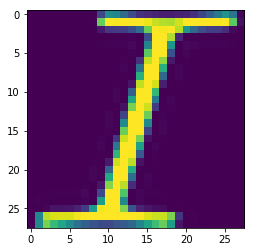

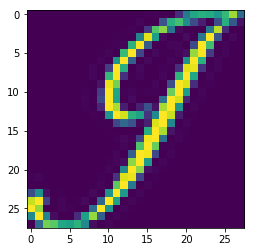

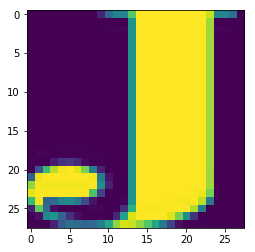

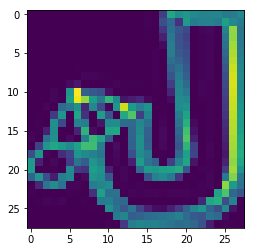

In [6]:
num_images = 0
for image_pickle in train_datasets:
    with open(image_pickle, 'rb') as image:
        letter_set = pickle.load(image)
        for i in range(3):
            sample_images = letter_set[np.random.randint(len(letter_set)), :, :]
            plt.figure()
            plt.imshow(sample_images)

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [7]:
for image_pickle in train_datasets:
    print(image_pickle + ":", pickle.load(open(image_pickle, 'rb')).shape[0], "images")
for image_pickle in test_datasets:
    print(image_pickle + ":", pickle.load(open(image_pickle, 'rb')).shape[0], "images")

./notMNIST_large/A.pickle: 52909 images
./notMNIST_large/B.pickle: 52911 images
./notMNIST_large/C.pickle: 52912 images
./notMNIST_large/D.pickle: 52911 images
./notMNIST_large/E.pickle: 52912 images
./notMNIST_large/F.pickle: 52912 images
./notMNIST_large/G.pickle: 52912 images
./notMNIST_large/H.pickle: 52912 images
./notMNIST_large/I.pickle: 52912 images
./notMNIST_large/J.pickle: 52911 images
./notMNIST_small/A.pickle: 1872 images
./notMNIST_small/B.pickle: 1873 images
./notMNIST_small/C.pickle: 1873 images
./notMNIST_small/D.pickle: 1873 images
./notMNIST_small/E.pickle: 1873 images
./notMNIST_small/F.pickle: 1872 images
./notMNIST_small/G.pickle: 1872 images
./notMNIST_small/H.pickle: 1872 images
./notMNIST_small/I.pickle: 1872 images
./notMNIST_small/J.pickle: 1872 images


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [8]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class
                    
                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 400000
valid_size = 18000
test_size = 18000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (400000, 28, 28) (400000,)
Validation: (18000, 28, 28) (18000,)
Testing: (18000, 28, 28) (18000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [9]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
---

Finally, let's save the data for later reuse:

In [10]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset,
        'train_labels': train_labels,
        'valid_dataset': valid_dataset,
        'valid_labels': valid_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [11]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1369040515


If you want to reload the data later, just do:

In [12]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (400000, 28, 28) (400000,)
Validation set (18000, 28, 28) (18000,)
Test set (18000, 28, 28) (18000,)


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [13]:
train_dataset.flags.writeable = False
valid_dataset.flags.writeable = False
test_dataset.flags.writeable = False

train_hash = [hash(letter.tobytes()) for letter in train_dataset]
valid_hash = [hash(letter.tobytes()) for letter in valid_dataset]
test_hash = [hash(letter.tobytes()) for letter in test_dataset]

unique_train_hash = set(train_hash)
valid_overlap = unique_train_hash.intersection(set(valid_hash))
test_overlap = unique_train_hash.intersection(set(test_hash))

print('Duplicates inside training set: ', len(train_hash) - len(unique_train_hash))
print('Duplicates between training and validation: ', len(valid_overlap))
print('Duplicates between training and test: ', len(test_overlap))

Duplicates inside training set:  41677
Duplicates between training and validation:  2937
Duplicates between training and test:  3484


---
Logistic Regression
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Here, we train a simple model on this data using 50, 100, 1000, 5000, 20K, 100K and 400K training samples.
We use the LogisticRegression model from sklearn.linear_model.

---

In [14]:
from sklearn.linear_model import LogisticRegression

def reshape_dataset(dataset):
    (samples, width, height) = dataset.shape
    return np.reshape(dataset, (samples, width * height))


train_scores = []
test_scores = []
training_samples = [50, 100, 1000, 5000, 20000, 100000, 400000]
for num_samples in training_samples:
    print(num_samples, "samples:")
    train_sample = train_dataset[:num_samples, :, :]
    train_sample_labels = train_labels[:num_samples]
    
    train_sample = reshape_dataset(train_sample)
    test_sample = reshape_dataset(test_dataset)
    
    model = LogisticRegression()
    model.fit(train_sample, train_sample_labels)
    
    train_score = model.score(train_sample, train_sample_labels)
    test_score = model.score(test_sample, test_labels)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print("Training score =", train_score)
    print("Testing score =", test_score)
    print("----------------------------------")

50 samples:
Training score = 1.0
Testing score = 0.604222222222
----------------------------------
100 samples:
Training score = 1.0
Testing score = 0.749722222222
----------------------------------
1000 samples:
Training score = 0.999
Testing score = 0.841166666667
----------------------------------
5000 samples:
Training score = 0.9414
Testing score = 0.848444444444
----------------------------------
20000 samples:
Training score = 0.8604
Testing score = 0.875722222222
----------------------------------
100000 samples:
Training score = 0.83585
Testing score = 0.89
----------------------------------
400000 samples:
Training score = 0.8298025
Testing score = 0.894388888889
----------------------------------


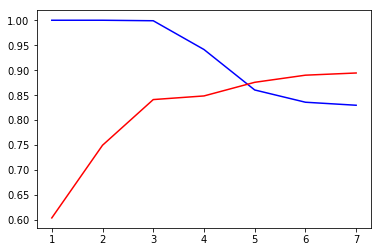

In [15]:
plt.plot([1, 2, 3, 4, 5, 6, 7], train_scores, 'b', [1, 2, 3, 4, 5, 6, 7], test_scores, 'r')
plt.show()

---
Neural Networks using TensorFlow
---------

---

# Gradient Descent

Now, we will progressively train deeper and more accurate models using TensorFlow.

Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [16]:
image_size = 28
num_labels = 10

def reformat_as_flat_matrix(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat_as_flat_matrix(train_dataset, train_labels)
valid_dataset, valid_labels = reformat_as_flat_matrix(valid_dataset, valid_labels)
test_dataset, test_labels = reformat_as_flat_matrix(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (400000, 784) (400000, 10)
Validation set (18000, 784) (18000, 10)
Test set (18000, 784) (18000, 10)


We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [127]:
def load_input_data(graph):
    with graph.as_default():
        tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
        tf_train_labels = tf.constant(train_labels[:train_subset])
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)
        return tf_train_dataset, tf_train_labels, tf_valid_dataset, tf_test_dataset


def init_weights_biases():
    # Variables.
    # These are the parameters that we are going to be training. The weight matrix will be initialized
    # using random values following a (truncated) normal distribution. The biases get initialized to zero.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    return weights, biases


def model(input_tensor, weights, biases):
    # Training computation.
    # We multiply the inputs with the weight matrix, and add biases.
    return tf.matmul(input_tensor, weights) + biases


def model_to_train(input_tensor, weights, biases):
    return model(input_tensor, weights, biases)


def model_to_test(input_tensor, weights, biases):
    return model(input_tensor, weights, biases)


def compute_cross_entropy(logits, tf_train_labels):
    return tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)


def compute_loss(logits, tf_train_labels, weights):
    return tf.reduce_mean(compute_cross_entropy(logits, tf_train_labels))


def get_optimizer(loss):
    return tf.train.GradientDescentOptimizer(0.5).minimize(loss)


def computation_graph(graph, tf_train_dataset, tf_train_labels, tf_valid_dataset, tf_test_dataset):
    with graph.as_default():
        # We compute the softmax and cross-entropy
        # (it's one operation in TensorFlow, because it's very common, and it can be optimized).
        # We take the average of this cross-entropy across all training examples: that's our loss.
        weights, biases = init_weights_biases()
        logits = model_to_train(tf_train_dataset, weights, biases)
        loss = compute_loss(logits, tf_train_labels, weights)

        # Optimizer.
        # We are going to find the minimum of this loss using gradient descent.
        optimizer = get_optimizer(loss)

        # Predictions for the training, validation, and test data.
        # These are not part of training, but merely here so that we can report accuracy figures as we train.
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model_to_test(tf_valid_dataset, weights, biases))
        test_prediction = tf.nn.softmax(model_to_test(tf_test_dataset, weights, biases))
        return optimizer, loss, train_prediction, valid_prediction, test_prediction


def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])


def iterate(graph, num_steps, optimizer, loss, train_prediction, valid_prediction, test_prediction):
    with tf.Session(graph=graph) as session:
        # This is a one-time operation which ensures the parameters get initialized as
        # we described in the graph: random weights for the matrix, zeros for the biases. 
        tf.global_variables_initializer().run()
        print('Initialized')
        for step in range(num_steps):
            # Run the computations. We tell .run() that we want to run the optimizer, and get the loss value
            # and the training predictions returned as numpy arrays.
            _, l, predictions = session.run([optimizer, loss, train_prediction])
            if (step % 100 == 0):
                print('-------')
                print('Loss at step %d: %f' % (step, l))
                print('Training accuracy: %.1f%%' % accuracy(predictions, train_labels[:train_subset, :]))
                # Calling .eval() on valid_prediction is basically like calling run(), but
                # just to get that one numpy array. Note that it recomputes all its graph dependencies.
                print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
        print('-------')
        print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

In [110]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000
num_steps = 801

graph = tf.Graph()
# Input data. Load the training, validation and test data into constants that are attached to the graph.
tf_train_dataset, tf_train_labels, tf_valid_dataset, tf_test_dataset = load_input_data(graph)
optimizer, loss, train_prediction, valid_prediction, test_prediction = computation_graph(graph,
                                                                                         tf_train_dataset,
                                                                                         tf_train_labels,
                                                                                         tf_valid_dataset,
                                                                                         tf_test_dataset)
iterate(graph, num_steps, optimizer, loss, train_prediction, valid_prediction, test_prediction)

Initialized
-------
Loss at step 0: 16.278185
Training accuracy: 11.2%
Validation accuracy: 14.6%
-------
Loss at step 100: 2.394785
Training accuracy: 71.5%
Validation accuracy: 70.7%
-------
Loss at step 200: 1.915577
Training accuracy: 74.3%
Validation accuracy: 73.0%
-------
Loss at step 300: 1.658333
Training accuracy: 75.8%
Validation accuracy: 73.9%
-------
Loss at step 400: 1.487956
Training accuracy: 76.9%
Validation accuracy: 74.5%
-------
Loss at step 500: 1.362990
Training accuracy: 77.7%
Validation accuracy: 74.7%
-------
Loss at step 600: 1.265904
Training accuracy: 78.1%
Validation accuracy: 74.9%
-------
Loss at step 700: 1.187110
Training accuracy: 78.5%
Validation accuracy: 75.1%
-------
Loss at step 800: 1.121062
Training accuracy: 79.0%
Validation accuracy: 75.2%
-------
Test accuracy: 82.9%


# Stochastic Gradient Descent

Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [128]:
def load_input_data(graph):
    with graph.as_default():
        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)
        return tf_train_dataset, tf_train_labels, tf_valid_dataset, tf_test_dataset

def iterate(graph, num_steps, optimizer, loss, train_prediction, valid_prediction, test_prediction):
    with tf.Session(graph=graph) as session:
        # This is a one-time operation which ensures the parameters get initialized as
        # we described in the graph: random weights for the matrix, zeros for the biases. 
        tf.global_variables_initializer().run()
        print('Initialized')
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                print('-------')
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
        print('-------')
        print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

In [112]:
batch_size = 128
num_steps = 3001

graph = tf.Graph()
tf_train_dataset, tf_train_labels, tf_valid_dataset, tf_test_dataset = load_input_data(graph)
optimizer, loss, train_prediction, valid_prediction, test_prediction = computation_graph(graph,
                                                                                         tf_train_dataset,
                                                                                         tf_train_labels,
                                                                                         tf_valid_dataset,
                                                                                         tf_test_dataset)
iterate(graph, num_steps, optimizer, loss, train_prediction, valid_prediction, test_prediction)

Initialized
-------
Minibatch loss at step 0: 17.987740
Minibatch accuracy: 8.6%
Validation accuracy: 11.8%
-------
Minibatch loss at step 500: 1.738158
Minibatch accuracy: 75.8%
Validation accuracy: 76.2%
-------
Minibatch loss at step 1000: 1.385029
Minibatch accuracy: 70.3%
Validation accuracy: 76.8%
-------
Minibatch loss at step 1500: 1.427042
Minibatch accuracy: 71.1%
Validation accuracy: 78.0%
-------
Minibatch loss at step 2000: 1.181921
Minibatch accuracy: 73.4%
Validation accuracy: 78.5%
-------
Minibatch loss at step 2500: 1.381069
Minibatch accuracy: 75.8%
Validation accuracy: 78.9%
-------
Minibatch loss at step 3000: 1.039913
Minibatch accuracy: 77.3%
Validation accuracy: 79.2%
-------
Test accuracy: 85.9%


# 1-hidden layer neural network with rectified linear units

We will use the rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

In [129]:
def init_weights_biases():
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([hidden_nodes]))
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    weights = [weights1, weights2]
    biases = [biases1, biases2]
    return weights, biases


def model(input_tensor, weights, biases):
    hidden_layer = tf.nn.relu(tf.matmul(input_tensor, weights[0]) + biases[0])
    return tf.matmul(hidden_layer, weights[1]) + biases[1]

In [114]:
batch_size = 128
hidden_nodes = 1024
num_steps = 3001

graph = tf.Graph()
tf_train_dataset, tf_train_labels, tf_valid_dataset, tf_test_dataset = load_input_data(graph)
optimizer, loss, train_prediction, valid_prediction, test_prediction = computation_graph(graph,
                                                                                         tf_train_dataset,
                                                                                         tf_train_labels,
                                                                                         tf_valid_dataset,
                                                                                         tf_test_dataset)
iterate(graph, num_steps, optimizer, loss, train_prediction, valid_prediction, test_prediction)

Initialized
-------
Minibatch loss at step 0: 327.851746
Minibatch accuracy: 8.6%
Validation accuracy: 33.1%
-------
Minibatch loss at step 500: 21.106367
Minibatch accuracy: 78.1%
Validation accuracy: 78.8%
-------
Minibatch loss at step 1000: 10.995174
Minibatch accuracy: 74.2%
Validation accuracy: 80.7%
-------
Minibatch loss at step 1500: 6.882022
Minibatch accuracy: 73.4%
Validation accuracy: 81.8%
-------
Minibatch loss at step 2000: 4.008643
Minibatch accuracy: 78.1%
Validation accuracy: 82.3%
-------
Minibatch loss at step 2500: 5.536816
Minibatch accuracy: 82.8%
Validation accuracy: 81.6%
-------
Minibatch loss at step 3000: 7.721065
Minibatch accuracy: 82.8%
Validation accuracy: 81.6%
-------
Test accuracy: 88.4%


# L2-regularization

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss.

In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

In [130]:
def compute_loss(logits, tf_train_labels, weights):
    added_l2_loss = 0
    for w in weights:
        added_l2_loss += tf.nn.l2_loss(w)
    reg = reg_coeff * added_l2_loss
    return tf.reduce_mean(compute_cross_entropy(logits, tf_train_labels)) + reg

In [118]:
batch_size = 128
hidden_nodes = 1024
reg_coeff = 1e-3
num_steps = 3001

graph = tf.Graph()
tf_train_dataset, tf_train_labels, tf_valid_dataset, tf_test_dataset = load_input_data(graph)
optimizer, loss, train_prediction, valid_prediction, test_prediction = computation_graph(graph,
                                                                                         tf_train_dataset,
                                                                                         tf_train_labels,
                                                                                         tf_valid_dataset,
                                                                                         tf_test_dataset)
iterate(graph, num_steps, optimizer, loss, train_prediction, valid_prediction, test_prediction)

Initialized
-------
Minibatch loss at step 0: 788.605103
Minibatch accuracy: 13.3%
Validation accuracy: 26.6%
-------
Minibatch loss at step 500: 206.790985
Minibatch accuracy: 76.6%
Validation accuracy: 76.4%
-------
Minibatch loss at step 1000: 119.330963
Minibatch accuracy: 64.1%
Validation accuracy: 80.7%
-------
Minibatch loss at step 1500: 69.856186
Minibatch accuracy: 76.6%
Validation accuracy: 82.2%
-------
Minibatch loss at step 2000: 41.682911
Minibatch accuracy: 77.3%
Validation accuracy: 83.7%
-------
Minibatch loss at step 2500: 25.658018
Minibatch accuracy: 80.5%
Validation accuracy: 85.2%
-------
Minibatch loss at step 3000: 15.470491
Minibatch accuracy: 82.0%
Validation accuracy: 85.8%
-------
Test accuracy: 91.7%


If you restrict your training data to just a few batches, since there are far too much parameters and no regularization, the accuracy of the batches is 100%. The generalization capability is poor, as shown in the validation and test accuracy.

# Dropout

Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

In [131]:
def model_to_train(input_tensor, weights, biases):
    hidden_layer = tf.nn.relu(tf.matmul(input_tensor, weights[0]) + biases[0])
    hidden_layer_dropout = tf.nn.dropout(hidden_layer, dropout_rate)
    return tf.matmul(hidden_layer_dropout, weights[1]) + biases[1]


def model_to_test(input_tensor, weights, biases):
    hidden_layer = tf.nn.relu(tf.matmul(input_tensor, weights[0]) + biases[0])
    return tf.matmul(hidden_layer, weights[1]) + biases[1]


def compute_loss(logits, tf_train_labels, weights):
    return tf.reduce_mean(compute_cross_entropy(logits, tf_train_labels))

In [122]:
batch_size = 128
hidden_nodes = 1024
dropout_rate = 0.5
num_steps = 8001

graph = tf.Graph()
tf_train_dataset, tf_train_labels, tf_valid_dataset, tf_test_dataset = load_input_data(graph)
optimizer, loss, train_prediction, valid_prediction, test_prediction = computation_graph(graph,
                                                                                         tf_train_dataset,
                                                                                         tf_train_labels,
                                                                                         tf_valid_dataset,
                                                                                         tf_test_dataset)
iterate(graph, num_steps, optimizer, loss, train_prediction, valid_prediction, test_prediction)

Initialized
-------
Minibatch loss at step 0: 561.339844
Minibatch accuracy: 3.9%
Validation accuracy: 28.2%
-------
Minibatch loss at step 500: 51.249382
Minibatch accuracy: 71.9%
Validation accuracy: 79.5%
-------
Minibatch loss at step 1000: 15.449528
Minibatch accuracy: 66.4%
Validation accuracy: 80.7%
-------
Minibatch loss at step 1500: 12.013401
Minibatch accuracy: 65.6%
Validation accuracy: 78.7%
-------
Minibatch loss at step 2000: 11.089350
Minibatch accuracy: 68.8%
Validation accuracy: 79.7%
-------
Minibatch loss at step 2500: 13.979595
Minibatch accuracy: 71.1%
Validation accuracy: 79.8%
-------
Minibatch loss at step 3000: 10.808839
Minibatch accuracy: 75.8%
Validation accuracy: 80.1%
-------
Minibatch loss at step 3500: 6.550483
Minibatch accuracy: 75.8%
Validation accuracy: 80.0%
-------
Minibatch loss at step 4000: 7.131936
Minibatch accuracy: 80.5%
Validation accuracy: 79.9%
-------
Minibatch loss at step 4500: 2.155873
Minibatch accuracy: 78.1%
Validation accuracy: 8

# 2-hidden layer neural network without dropout and without L2-regularization


Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

In [134]:
def init_weights_biases():
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes1],
                                               stddev=np.sqrt(2.0 / (image_size * image_size))))
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes1, hidden_nodes2],
                                               stddev=np.sqrt(2.0 / hidden_nodes1)))
    weights3 = tf.Variable(tf.truncated_normal([hidden_nodes2, num_labels],
                                              stddev=np.sqrt(2.0 / hidden_nodes2)))
    biases1 = tf.Variable(tf.zeros([hidden_nodes1]))
    biases2 = tf.Variable(tf.zeros([hidden_nodes2]))
    biases3 = tf.Variable(tf.zeros([num_labels]))
    
    weights = [weights1, weights2, weights3]
    biases = [biases1, biases2, biases3]
    return weights, biases


def model_to_train(input_tensor, weights, biases):
    hidden_layer1 = tf.nn.relu(compute_xw_b(input_tensor, weights[0], biases[0]))
    hidden_layer2 = tf.nn.relu(compute_xw_b(hidden_layer1, weights[1], biases[1]))
    return compute_xw_b(hidden_layer2, weights[2], biases[2])


def model_to_test(input_tensor, weights, biases):
    return model_to_train(input_tensor, weights, biases)

In [135]:
batch_size = 128
hidden_nodes1 = 1024
hidden_nodes2 = 100
num_steps = 8001

graph = tf.Graph()
tf_train_dataset, tf_train_labels, tf_valid_dataset, tf_test_dataset = load_input_data(graph)
optimizer, loss, train_prediction, valid_prediction, test_prediction = computation_graph(graph,
                                                                                         tf_train_dataset,
                                                                                         tf_train_labels,
                                                                                         tf_valid_dataset,
                                                                                         tf_test_dataset)
iterate(graph, num_steps, optimizer, loss, train_prediction, valid_prediction, test_prediction)

Initialized
-------
Minibatch loss at step 0: 2.300956
Minibatch accuracy: 13.3%
Validation accuracy: 41.4%
-------
Minibatch loss at step 500: 0.555408
Minibatch accuracy: 82.8%
Validation accuracy: 86.0%
-------
Minibatch loss at step 1000: 0.453175
Minibatch accuracy: 89.1%
Validation accuracy: 87.4%
-------
Minibatch loss at step 1500: 0.478890
Minibatch accuracy: 83.6%
Validation accuracy: 88.5%
-------
Minibatch loss at step 2000: 0.334445
Minibatch accuracy: 87.5%
Validation accuracy: 88.8%
-------
Minibatch loss at step 2500: 0.444051
Minibatch accuracy: 85.9%
Validation accuracy: 89.2%
-------
Minibatch loss at step 3000: 0.381622
Minibatch accuracy: 87.5%
Validation accuracy: 89.4%
-------
Minibatch loss at step 3500: 0.330285
Minibatch accuracy: 90.6%
Validation accuracy: 89.7%
-------
Minibatch loss at step 4000: 0.304765
Minibatch accuracy: 89.1%
Validation accuracy: 90.0%
-------
Minibatch loss at step 4500: 0.267507
Minibatch accuracy: 91.4%
Validation accuracy: 89.5%
--

# 2-hidden layer neural network with L2-regularization

In [136]:
def compute_loss(logits, tf_train_labels, weights):
    added_l2_loss = 0
    for w in weights:
        added_l2_loss += tf.nn.l2_loss(w)
    reg = reg_coeff * added_l2_loss
    return tf.reduce_mean(compute_cross_entropy(logits, tf_train_labels)) + reg

In [137]:
batch_size = 128
hidden_nodes1 = 1024
hidden_nodes2 = 100
reg_coeff = 1e-3
num_steps = 8001

graph = tf.Graph()
tf_train_dataset, tf_train_labels, tf_valid_dataset, tf_test_dataset = load_input_data(graph)
optimizer, loss, train_prediction, valid_prediction, test_prediction = computation_graph(graph,
                                                                                         tf_train_dataset,
                                                                                         tf_train_labels,
                                                                                         tf_valid_dataset,
                                                                                         tf_test_dataset)
iterate(graph, num_steps, optimizer, loss, train_prediction, valid_prediction, test_prediction)

Initialized
-------
Minibatch loss at step 0: 3.286251
Minibatch accuracy: 4.7%
Validation accuracy: 32.2%
-------
Minibatch loss at step 500: 1.132833
Minibatch accuracy: 83.6%
Validation accuracy: 85.9%
-------
Minibatch loss at step 1000: 0.824731
Minibatch accuracy: 85.2%
Validation accuracy: 87.0%
-------
Minibatch loss at step 1500: 0.788406
Minibatch accuracy: 82.0%
Validation accuracy: 87.4%
-------
Minibatch loss at step 2000: 0.556268
Minibatch accuracy: 88.3%
Validation accuracy: 88.5%
-------
Minibatch loss at step 2500: 0.646164
Minibatch accuracy: 86.7%
Validation accuracy: 88.0%
-------
Minibatch loss at step 3000: 0.534072
Minibatch accuracy: 85.2%
Validation accuracy: 88.5%
-------
Minibatch loss at step 3500: 0.517133
Minibatch accuracy: 89.8%
Validation accuracy: 88.5%
-------
Minibatch loss at step 4000: 0.449454
Minibatch accuracy: 89.1%
Validation accuracy: 88.7%
-------
Minibatch loss at step 4500: 0.411913
Minibatch accuracy: 89.8%
Validation accuracy: 88.4%
---

# 2-hidden layer neural network with another learning rate decay

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

In [ ]:
def get_optimizer(loss):
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    return tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

In [ ]:
batch_size = 128
hidden_nodes1 = 1024
hidden_nodes2 = 100
reg_coeff = 1e-3

def compute_xw_b(x, w, b):
    return tf.matmul(x, w) + b

def forward_propagation(dataset, weights1, biases1, weights2, biases2):
    hidden_layer = tf.nn.relu(compute_xw_b(dataset, weights1, biases1))
    logits = compute_xw_b(hidden_layer, weights2, biases2)
    return logits

def forward_propagation_with_dropout(dataset, weights1, biases1, weights2, biases2, keep_prob):
    hidden_layer = tf.nn.relu(compute_xw_b(dataset, weights1, biases1))
    hidden_layer_dropout = tf.nn.dropout(hidden_layer, keep_prob)
    logits = compute_xw_b(hidden_layer_dropout, weights2, biases2)
    return logits

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes1],
                                               stddev=np.sqrt(2.0 / (image_size * image_size))))
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes1, hidden_nodes2],
                                               stddev=np.sqrt(2.0 / hidden_nodes1)))
    weights3 = tf.Variable(tf.truncated_normal([hidden_nodes2, num_labels],
                                              stddev=np.sqrt(2.0 / hidden_nodes2)))
    biases1 = tf.Variable(tf.zeros([hidden_nodes1]))
    biases2 = tf.Variable(tf.zeros([hidden_nodes2]))
    biases3 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    # Insert a 2-hidden layer neural network with relu and respectively 1024 hidden nodes and 100 hidden nodes
    hidden_layer1 = tf.nn.relu(compute_xw_b(tf_train_dataset, weights1, biases1))
    hidden_layer2 = tf.nn.relu(compute_xw_b(hidden_layer1, weights2, biases2))
    logits = compute_xw_b(hidden_layer2, weights3, biases3)
    regularizers = reg_coeff * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))\
        + regularizers
    
    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    h1_valid = tf.nn.relu(compute_xw_b(tf_valid_dataset, weights1, biases1))
    h2_valid = tf.nn.relu(compute_xw_b(h1_valid, weights2, biases2))
    valid_prediction = tf.nn.softmax(compute_xw_b(h2_valid, weights3, biases3))
    
    h1_test = tf.nn.relu(compute_xw_b(tf_test_dataset, weights1, biases1))
    h2_test = tf.nn.relu(compute_xw_b(h1_test, weights2, biases2))
    test_prediction = tf.nn.softmax(compute_xw_b(h2_test, weights3, biases3))

In [ ]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('-------')
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print('-------')
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Nice! Let's try with dropout:

In [ ]:
batch_size = 128
hidden_nodes1 = 1024
hidden_nodes2 = 100
dropout_rate = 0.5
reg_coeff = 1e-3

def compute_xw_b(x, w, b):
    return tf.matmul(x, w) + b

def forward_propagation(dataset, weights1, biases1, weights2, biases2):
    hidden_layer = tf.nn.relu(compute_xw_b(dataset, weights1, biases1))
    logits = compute_xw_b(hidden_layer, weights2, biases2)
    return logits

def forward_propagation_with_dropout(dataset, weights1, biases1, weights2, biases2, keep_prob):
    hidden_layer = tf.nn.relu(compute_xw_b(dataset, weights1, biases1))
    hidden_layer_dropout = tf.nn.dropout(hidden_layer, keep_prob)
    logits = compute_xw_b(hidden_layer_dropout, weights2, biases2)
    return logits

graph = tf.Graph()
with graph.as_default():

    # Input data.
    # For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # Variables.
    weights1 = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_nodes1],
                                               stddev=np.sqrt(2.0 / (image_size * image_size))))
    weights2 = tf.Variable(tf.truncated_normal([hidden_nodes1, hidden_nodes2],
                                               stddev=np.sqrt(2.0 / hidden_nodes1)))
    weights3 = tf.Variable(tf.truncated_normal([hidden_nodes2, num_labels],
                                              stddev=np.sqrt(2.0 / hidden_nodes2)))
    biases1 = tf.Variable(tf.zeros([hidden_nodes1]))
    biases2 = tf.Variable(tf.zeros([hidden_nodes2]))
    biases3 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    # Insert a 2-hidden layer neural network with relu and respectively 1024 hidden nodes and 100 hidden nodes
    hidden_layer1 = tf.nn.dropout(tf.nn.relu(compute_xw_b(tf_train_dataset, weights1, biases1)), 0.5)
    hidden_layer2 = tf.nn.dropout(tf.nn.relu(compute_xw_b(hidden_layer1, weights2, biases2)), 0.5)
    logits = compute_xw_b(hidden_layer2, weights3, biases3)
    regularizers = reg_coeff * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))\
        + regularizers
    
    # Optimizer.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    
    h1_valid = tf.nn.relu(compute_xw_b(tf_valid_dataset, weights1, biases1))
    h2_valid = tf.nn.relu(compute_xw_b(h1_valid, weights2, biases2))
    valid_prediction = tf.nn.softmax(compute_xw_b(h2_valid, weights3, biases3))
    
    h1_test = tf.nn.relu(compute_xw_b(tf_test_dataset, weights1, biases1))
    h2_test = tf.nn.relu(compute_xw_b(h1_test, weights2, biases2))
    test_prediction = tf.nn.softmax(compute_xw_b(h2_test, weights3, biases3))

In [ ]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('-------')
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print('-------')
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

# Convolutional Networks

Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [ ]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

In [ ]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [ ]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
num_channels = 1 # greyscale

graph = tf.Graph()

with graph.as_default():

  # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [ ]:
num_steps = 1001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('-------')
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print('-------')
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [ ]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
num_channels = 1 # greyscale

graph = tf.Graph()

with graph.as_default():

  # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
        conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [ ]:
num_steps = 1001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('-------')
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print('-------')
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [ ]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
num_channels = 1 # greyscale

graph = tf.Graph()

with graph.as_default():

  # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    new_size = ((image_size - patch_size + 1) // 2 - patch_size + 1) // 2
    layer3_weights = tf.Variable(tf.truncated_normal([new_size * new_size * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
    def model(data):
        # 28 x 28
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
        hidden = tf.nn.relu(conv + layer1_biases)
        # 24 x 24
        pool = tf.nn.avg_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        
        # 12 x 12
        conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='VALID')
        hidden = tf.nn.relu(conv + layer2_biases)
        # 8 x 8
        pool = tf.nn.avg_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        
        # 4 x 4
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [ ]:
num_steps = 5001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('-------')
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print('-------')
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Now let's add dropout and use a learning rate decay:

In [ ]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
num_channels = 1 # greyscale

graph = tf.Graph()

with graph.as_default():

  # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    global_step = tf.Variable(0)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    new_size = ((image_size - patch_size + 1) // 2 - patch_size + 1) // 2
    layer3_weights = tf.Variable(tf.truncated_normal([new_size * new_size * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
    def model(data, dropout):
        # 28 x 28
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
        hidden = tf.nn.relu(conv + layer1_biases)
        # 24 x 24
        pool = tf.nn.avg_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        
        # 12 x 12
        conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='VALID')
        hidden = tf.nn.relu(conv + layer2_biases)
        # 8 x 8
        pool = tf.nn.avg_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
        
        # 4 x 4
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.dropout(tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases), dropout)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset, 0.5)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

    # Optimizer.
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 1000, 0.85, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset, 1.0))
    test_prediction = tf.nn.softmax(model(tf_test_dataset, 1.0))

In [ ]:
num_steps = 5001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print('-------')
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print('-------')
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))